# Dados e Aprendizagem Automática
## Trabalho Prático
### Grupo 13
### Membros:
- (PG50304) Cristiano Pereira
- (PG50463) João Martins
- (PG50506) Jorge Lima
- (PG50733) Rúben Santos

### Dataset: Paris Airbnb (http://insideairbnb.com/)

Notebook structure:
- 1. Installing libraries
- 2. Importing libraries
- 3. Loading the dataset
- 4. Exploratory Data Analysis
    - 4.1. General information
    - 4.2. Neighborhoods
    - 4.3. Room type
    - 4.4. Expected Revenue
    - 4.5. Number of reviews
    - 4.6. Hosts
    - 4.7. Last review
    - 4.8. License
- 5. Data Preprocessing
    - 5.1  Encoding Categorical variables
    - 5.2. Missing values
    - 5.3. Outliers
    - 5.4. Correlation
- 6. Model Training
    - 6.1. Linear Regression
    - 6.2. Decision Tree Regression
    - 6.3. Random Forest Regression
    - 6.4. Support Vector Regression
    - 6.5. XGBoost Regression
    - 6.6. Artificial Neural Network
    - ...
- 7. Model Evaluation
    - 7.1. Linear Regression
    - 7.2. Decision Tree Regression
    - 7.3. Random Forest Regression
    - 7.4. Support Vector Regression
    - 7.5. XGBoost Regression
    - 7.6. Artificial Neural Network
    - ...
- 8. Model Selection
- 9. Model Tuning
- 10. Model Evaluation
- 11. Conclusion

## 1. Installing libraries

In [1]:
# TODO: List of pip install commands
#
# Install the required packages
# 
# %pip install lois
# %pip install pandas-profiling
# %pip install ipywidgets
# ...

## 2. Importing libraries

In [2]:
# TODO: Describe packages used
#
# Import the required packages

#Pandas stack
import pandas as pd
import pandas_profiling

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Lois for EDA
from lois import lois_ds_report

# sklearn
import sklearn

import numpy as np

%matplotlib inline

## 3. Loading the dataset

In [3]:
# Load Paris airbnb data
paris_data = pd.read_csv('../data/ParisAirbnb.csv')

## 4. Exploratory Data Analysis
### 4.1. General information

In [4]:
# The neighbourhood_group column has no values, we can drop it.
if 'neighbourhood_group' in paris_data.columns:
    paris_data = paris_data.drop('neighbourhood_group', axis=1)

if 'id' in paris_data.columns:
    paris_data = paris_data.drop('id', axis=1)

if 'latitude' in paris_data.columns:
    paris_data = paris_data.drop('latitude', axis=1)
    
if 'longitude' in paris_data.columns:
    paris_data = paris_data.drop('longitude', axis=1)

if 'name' in paris_data.columns:
    paris_data = paris_data.drop('name', axis=1)

╭─────────────────────────────────────────── Exploratory Data Anlysis ────────────────────────────────────────────╮
│                                                                                                                 │
╰──────────────────────────────────── EDA|simple| Suitable for data scientist ────────────────────────────────────╯

EDA
┗━━ Dataset Shape Analysis
    ┣━━ Dataset head
    ┣━━ General info 
    ┣━━ The target variable
    ┣━━ Number of rows and columns
    ┣━━ The different data types
    ┃   ┣━━ The sum of different variable type
    ┃   ┗━━ Visual representation of different variable type
    ┗━━ Analyze missing value
        ┣━━ The percentage of missing value in each columns
        ┣━━ The missing value counts
        ┗━━ Visual representation of missing value

╭──────────────────────────────────────────── DATASET SHAPE ANALYSIS ─────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

-------------------- THE HEAD OF YOUR DATASET --------------------

Your dataset is too large ; only the first 8 columns will be display

                                                    The Dataset                                                    
┏━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ host… ┃ host_n… ┃ neighbourh… ┃ room_t… ┃ pri… ┃ minimum_nig… ┃ number_of_revie… ┃ last_rev… ┃ reviews_per_mon… ┃
┡━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
└───────┴─────────┴─────────────┴─────────┴──────┴──────────────┴──────────────────┴───────────┴──────────────────┘

-------------------- SOME GENERAL INFO ABOUT YOUR DATASET --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61365 entries, 0 to 61364
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         61365 non-null  int64  
 1   host_name                       61358 non-null  object 
 2   neighbourhood                   61365 non-null  object 
 3   room_type                       61365 non-null  object 
 4   price                           61365 non-null  int64  
 5   minimum_nights                  61365 non-null  int64  
 6   number_of_reviews               61365 non-null  int64  
 7   last_review                     49485 non-null  object 
 8   reviews_per_month               49485 non-null  float64
 9   calculated_host_listings_count  61365 non-null  int64  
 10  availability_365                61365 non-null  int64  
 11  number_of_reviews_ltm           61365 non-null  int64  
 12  license                         

-------------------- THE TARGET VARIABLE OF YOUR DATASET --------------------

╭───────────────────────────────────╮
│ The Target variable is : 'price'  │
╰───────────────────────────────────╯

-------------------- ROWS AND COLUMNS IN YOUR DATASET --------------------

╭─ Shape output ─╮
│ (61365, 13)    │
╰────────────────╯

╭─────────────────────────────────────────────────╮
│ Your dataset contains 61365 Rows and 13 Columns │
╰─────────────────────────────────────────────────╯

-------------------- THE DATA TYPES IN YOUR DATASET --------------------

╭─ Data types output ─╮
│ int64      7        │
│ object     5        │
│ float64    1        │
│ dtype: int64        │
╰─────────────────────╯

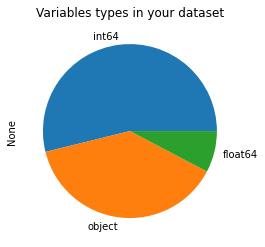

-------------------- MISSING VALUE IN YOUR DATASET --------------------

╭─────────── Missing value output ───────────╮
│ host_id                           0.000000 │
│ neighbourhood                     0.000000 │
│ room_type                         0.000000 │
│ price                             0.000000 │
│ minimum_nights                    0.000000 │
│ number_of_reviews                 0.000000 │
│ calculated_host_listings_count    0.000000 │
│ availability_365                  0.000000 │
│ number_of_reviews_ltm             0.000000 │
│ host_name                         0.000114 │
│ last_review                       0.193596 │
│ reviews_per_month                 0.193596 │
│ license                           0.398419 │
│ dtype: float64                             │
╰────────────────────────────────────────────╯

╭─ Missing value counts output ─╮
│ 0.398419    1                 │
│ 0.000114    1                 │
│ 0.193596    2                 │
│ 0.000000    9                 │
│ dtype: int64                  │
╰───────────────────────────────╯

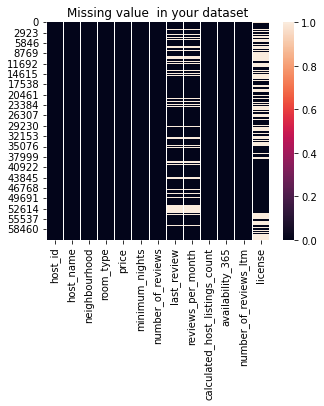

#################### END ####################

In [5]:
# Get lois EDA report
lois_ds_report(paris_data, target_variable='price')

In [6]:
paris_data.describe()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,6.136500e+04,61365.000000,61365.000000,61365.000000,49485.000000,61365.000000,61365.000000,61365.000000
mean,1.211832e+08,161.811326,81.193514,23.910894,1.095936,11.083207,106.526945,7.229007
std,1.448137e+08,301.441306,151.562180,51.986093,1.574085,35.334404,130.754534,17.841936
min,2.750000e+02,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,1.513374e+07,70.000000,2.000000,1.000000,0.170000,1.000000,0.000000,0.000000
50%,4.756324e+07,100.000000,3.000000,6.000000,0.570000,1.000000,26.000000,1.000000
75%,1.933977e+08,170.000000,30.000000,24.000000,1.480000,2.000000,231.000000,8.000000
max,4.787753e+08,12286.000000,9999.000000,2391.000000,89.900000,269.000000,365.000000,1356.000000


### 4.2. Neighborhoods

Text(0, 0.5, 'Number of listings')

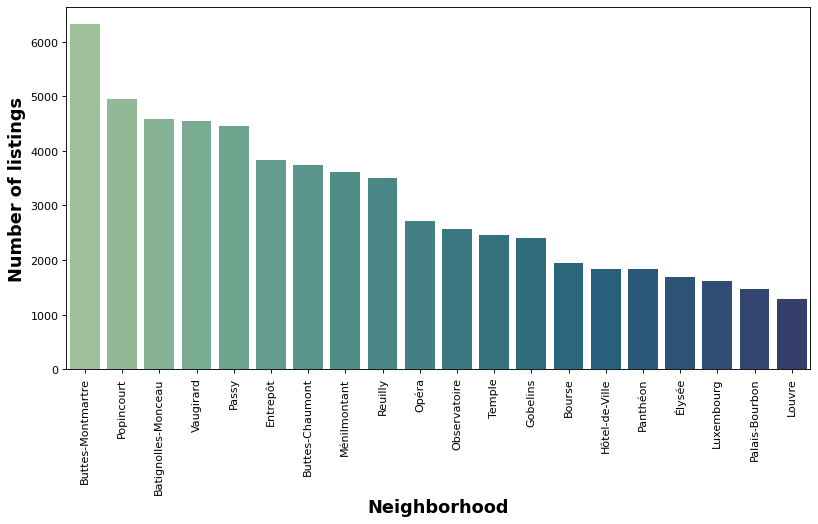

In [7]:
# Explore the number of listings per neighbourhood
_, ax = plt.subplots(figsize = (12,6), dpi = 80)
sns.countplot(x=paris_data['neighbourhood'], palette='crest', ax=ax, order=paris_data['neighbourhood'].value_counts().index)
ax.set_xlabel('Neighborhood', fontdict={'color':'black', 'weight':'bold', 'size': 16})
plt.xticks(rotation=90)
ax.set_ylabel('Number of listings', fontdict={'color':'black', 'weight':'bold', 'size': 16})

In [8]:
# Get top 5 neighbourhoods with the most listings and their counts.
print(paris_data['neighbourhood'].value_counts().head(5))

Buttes-Montmartre      6317
Popincourt             4947
Batignolles-Monceau    4590
Vaugirard              4542
Passy                  4453
Name: neighbourhood, dtype: int64


As we can see in the graph and table above, the most popular neighbourhood is Buttes-Montmartre, with 6317 listings. The rest of the top five are very close to each other.

Text(0, 0.5, 'Price per night')

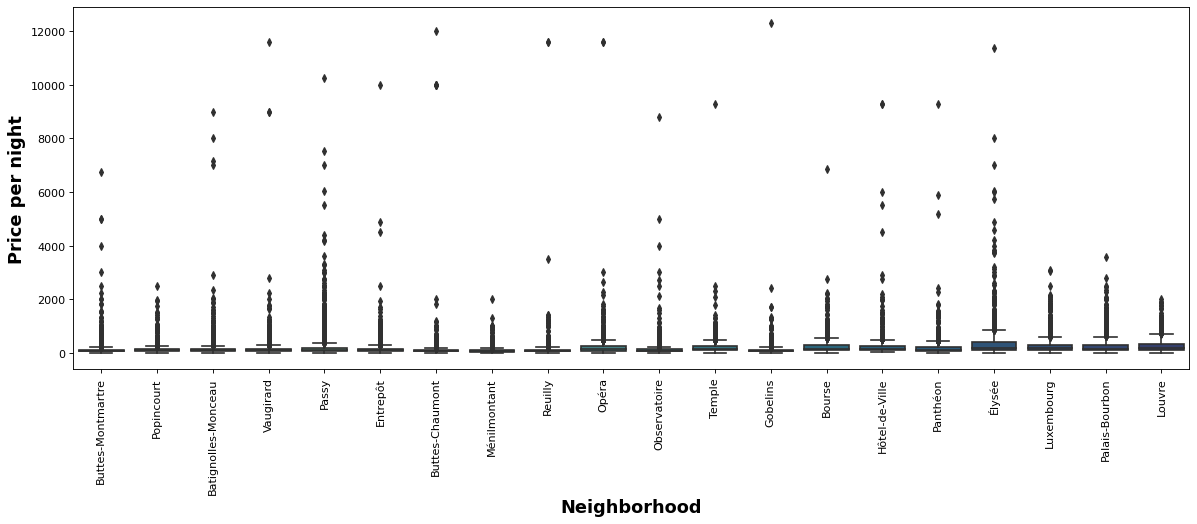

In [9]:
# Plot the price per night distribution per neighbourhood.
_, ax = plt.subplots(figsize = (18,6), dpi = 80)
sns.boxplot(x=paris_data['neighbourhood'], y=paris_data['price'], ax=ax, palette='crest', order=paris_data['neighbourhood'].value_counts().index)
plt.xticks(rotation=90)
ax.set_xlabel('Neighborhood', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('Price per night', fontdict={'color':'black', 'weight':'bold', 'size': 16})

In [10]:
# Get average price per night per neighbourhood (top 10).
print("There are {} different neighbourhoods in Paris.".format(len(paris_data['neighbourhood'].unique())))
print(paris_data.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(10))

There are 20 different neighbourhoods in Paris.
neighbourhood
Élysée            366.793717
Louvre            277.885335
Palais-Bourbon    260.010169
Luxembourg        254.884923
Hôtel-de-Ville    234.874591
Bourse            228.300412
Opéra             206.615724
Temple            206.536615
Passy             203.225691
Panthéon          200.008729
Name: price, dtype: float64


As we can see in the graph and table above, the most expensive neighbourhoods are Élysée, Louvre and Passy. At least half of the neighbourhoods have a price above 200€.

Also, there are a few outliers that must be handled.

### 4.3. Room type

There are 4 different room types in Paris.
['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


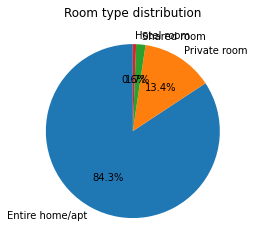

In [11]:
# Get unique values for room type.
print("There are {} different room types in Paris.".format(len(paris_data['room_type'].unique())))
print(paris_data['room_type'].unique())

# Get room type distribution.
plt.pie(paris_data['room_type'].value_counts(), labels=paris_data['room_type'].unique(), autopct='%1.1f%%', startangle=90)
plt.title('Room type distribution')
plt.show()


The majority of the listings are entire homes or apartments, followed by private rooms and shared rooms. Togheter, they represent 97.7% of the listings.

Text(0, 0.5, 'Room type')

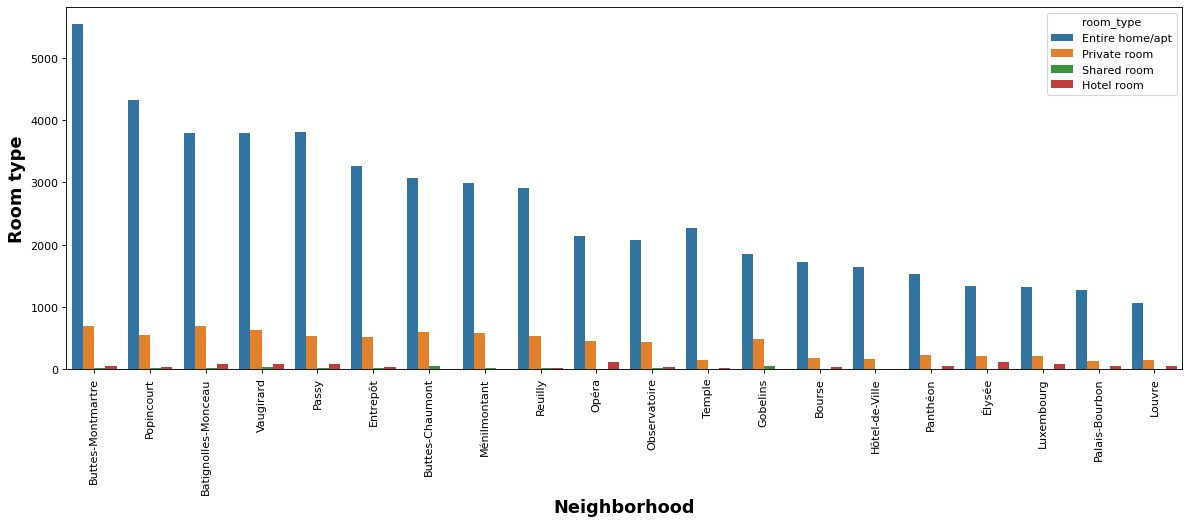

In [12]:
# Plot the room type distribution per neighbourhood.
_, ax = plt.subplots(figsize = (18,6), dpi = 80)
sns.countplot(x=paris_data['neighbourhood'], hue=paris_data['room_type'], ax=ax, order=paris_data['neighbourhood'].value_counts().index)
ax.set_xlabel('Neighborhood', fontdict={'color':'black', 'weight':'bold', 'size': 16})
plt.xticks(rotation=90)
ax.set_ylabel('Room type', fontdict={'color':'black', 'weight':'bold', 'size': 16})

In [13]:
# Get neighbourhoods with the most hotels.
print(paris_data[paris_data['room_type'] == 'Hotel room']['neighbourhood'].value_counts().head(10))

Élysée                 125
Opéra                  121
Passy                   89
Luxembourg              86
Vaugirard               83
Batignolles-Monceau     80
Louvre                  60
Buttes-Montmartre       57
Palais-Bourbon          56
Panthéon                52
Name: neighbourhood, dtype: int64


In [14]:
# Get neighbourhoods with the most shared rooms.
print(paris_data[paris_data['room_type'] == 'Shared room']['neighbourhood'].value_counts().head(10))

Buttes-Chaumont        54
Gobelins               51
Vaugirard              35
Reuilly                27
Ménilmontant           25
Popincourt             22
Batignolles-Monceau    22
Buttes-Montmartre      21
Passy                  20
Entrepôt               18
Name: neighbourhood, dtype: int64


The most expensive neighbourhoods tend to have more hotel rooms, while the cheapest neighbourhoods tend to have more shared rooms. Remember that these two types of rooms amount to only 2.3% of the listings.

Text(0, 0.5, 'Price per night')

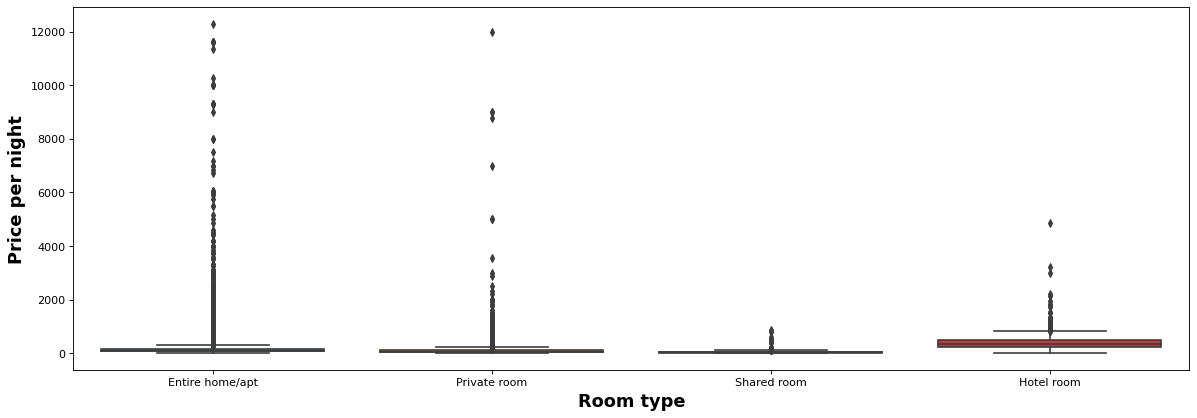

In [15]:
# Plot the price per night distribution per room type.
_, ax = plt.subplots(figsize = (18,6), dpi = 80)
sns.boxplot(x=paris_data['room_type'], y=paris_data['price'])
ax.set_xlabel('Room type', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('Price per night', fontdict={'color':'black', 'weight':'bold', 'size': 16})

In [16]:
# Get average price per night per room type.
print('Average price per night per room type:')
print(paris_data.groupby('room_type')['price'].mean().sort_values(ascending=False))

Average price per night per room type:
room_type
Hotel room         404.586792
Entire home/apt    161.791770
Private room       135.302068
Shared room         58.796247
Name: price, dtype: float64


Again, we have a few outliers that must be handled.

### 4.4. Expected Revenue

An interesting feature to analyze is the expected revenue. It is calculated by multiplying the price by the availability_365. This is a good way to see how much money the host can expect to earn.

In [17]:
# Get most common values (and count) for availability_365.
print('The most common values for availability_365 are:')
print(paris_data['availability_365'].value_counts().head(5))

# Get percentage of listings with 0 days availability per year.
print('Percentage of listings with 0 days availability per year is: {}%'.format(round(paris_data[paris_data['availability_365'] == 0].shape[0] / paris_data.shape[0] * 100, 2)))

The most common values for availability_365 are:
0      24837
365      819
1        785
2        546
252      481
Name: availability_365, dtype: int64
Percentage of listings with 0 days availability per year is: 40.47%


Short of (40%) of the listings have an expected revenue of 0€. This is because they are not available for the whole year. It is unclear the reason for this, but it is probably because the host is not interested in renting the place for the the time being. Or maybe the host just forgot to update the availability.

In [18]:
# Add the expected revenue (in thousands) per listing per year to the dataset.
paris_data['expected_revenue'] = paris_data['price'] * paris_data['availability_365'] / 1000

### 4.5. Number of reviews

Text(0, 0.5, 'Number of reviews')

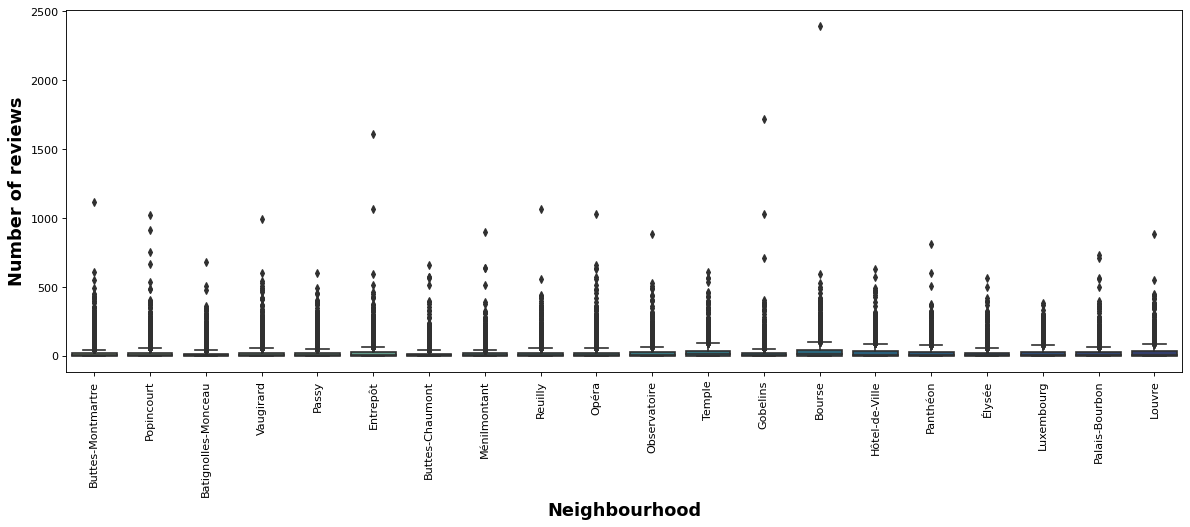

In [19]:
# Plot the number of reviews distribution per neighbourhood.
_, ax = plt.subplots(figsize = (18,6), dpi = 80)
sns.boxplot(x=paris_data['neighbourhood'], y=paris_data['number_of_reviews'], ax=ax, palette='crest', order=paris_data['neighbourhood'].value_counts().index)
ax.set_xlabel('Neighbourhood', fontdict={'color':'black', 'weight':'bold', 'size': 16})
plt.xticks(rotation=90)
ax.set_ylabel('Number of reviews', fontdict={'color':'black', 'weight':'bold', 'size': 16})

In [20]:
# Get most reviewed listing per neighbourhood.
print(paris_data.groupby('neighbourhood')['number_of_reviews'].max().sort_values(ascending=False).head(5))

neighbourhood
Bourse               2391
Gobelins             1720
Entrepôt             1608
Buttes-Montmartre    1118
Reuilly              1067
Name: number_of_reviews, dtype: int64


In [21]:
# Get average number of reviews per neighbourhood.
print(paris_data.groupby('neighbourhood')['number_of_reviews'].mean().sort_values(ascending=False).head(5))

neighbourhood
Bourse            39.560700
Louvre            34.468019
Temple            33.855574
Hôtel-de-Ville    32.737186
Panthéon          29.667758
Name: number_of_reviews, dtype: float64


In [22]:
# Get top 10 neighbourhoods with the most reviews.
print(paris_data.groupby('neighbourhood')['number_of_reviews'].sum().sort_values(ascending=False).head(10))

neighbourhood
Buttes-Montmartre      126682
Popincourt             114563
Vaugirard              106798
Entrepôt                98368
Passy                   89703
Reuilly                 85521
Temple                  83217
Batignolles-Monceau     80267
Bourse                  76906
Opéra                   69996
Name: number_of_reviews, dtype: int64


The number of reviews is higher (expectedly) for the neighbourhoods that have more listings. There are a few outliers that have a lot of reviews, something like 60 times more thant the neighbourhood average. This is probably because the host is very popular.

### 4.6. Hosts

To check if there is such thing as popular hosts, we can pick the hosts with most reviews.

In [23]:
# Check if the same host_id always has the same host_name
count_host_id_name_misses = 0
hosts_to_remove = []
dic = {}
if 'host_name' in paris_data.columns and 'host_id' in paris_data.columns:
    for host_id, host_name in zip(paris_data.host_id, paris_data.host_name):
        if host_id in dic.keys():
            if dic[host_id] != host_name:
                hosts_to_remove.append(host_id)
                count_host_id_name_misses += 1
                print('Host id {} has different host name {} and {}.'.format(host_id, dic[host_id], host_name))
        else:
            dic[host_id] = host_name

    print('Number of host_id that has different host_name: {}'.format(count_host_id_name_misses))
    
    # Remove hosts with different host_id and host_name.
    paris_data = paris_data[~paris_data['host_id'].isin(hosts_to_remove)]
    
    # Drop host_name column.
    paris_data.drop('host_name', axis=1, inplace=True)

Host id 1721954 has different host name nan and nan.
Number of host_id that has different host_name: 1


In [24]:
# Get the most popular hosts (top 10).
hosts_reviews = paris_data.groupby(['host_id']).sum().sort_values(by='number_of_reviews', ascending=False).iloc[:10]
hosts_reviews = hosts_reviews.rename_axis('host_id').reset_index()
id_name = paris_data[['host_id']]
hosts_reviews = pd.merge(id_name, hosts_reviews, on='host_id').drop_duplicates().sort_values(by='number_of_reviews', ascending=False)

# Show only host_id and number_of_reviews
top_ten_hosts_reviews = hosts_reviews[['host_id', 'number_of_reviews']]

# Get the number of listings of the top 10 hosts with the most reviews.

top_ten_hosts_reviews_listings = paris_data[paris_data['host_id'].isin(top_ten_hosts_reviews['host_id'])].groupby(['host_id']).count().sort_values(by='number_of_reviews', ascending=False).iloc[:10]
top_ten_hosts_reviews_listings = top_ten_hosts_reviews_listings.rename_axis('host_id').reset_index()
id_name = paris_data[['host_id']]
top_ten_hosts_reviews_listings = pd.merge(id_name, top_ten_hosts_reviews_listings, on='host_id').drop_duplicates().sort_values(by='number_of_reviews', ascending=False)
top_ten_hosts_reviews_listings = top_ten_hosts_reviews_listings[['host_id', 'neighbourhood']]
top_ten_hosts_reviews_listings = top_ten_hosts_reviews_listings.rename(columns={'neighbourhood': 'number_of_listings'})

top_ten_hosts_expected_revenue = paris_data[paris_data['host_id'].isin(top_ten_hosts_reviews['host_id'])].groupby(['host_id']).sum().sort_values(by='expected_revenue', ascending=False).iloc[:10]
top_ten_hosts_expected_revenue = top_ten_hosts_expected_revenue.rename_axis('host_id').reset_index()
id_name = paris_data[['host_id']]
top_ten_hosts_expected_revenue = pd.merge(id_name, top_ten_hosts_expected_revenue, on='host_id').drop_duplicates().sort_values(by='expected_revenue', ascending=False)
top_ten_hosts_expected_revenue = top_ten_hosts_expected_revenue[['host_id', 'expected_revenue']]

# Averate number of reviews per host.
print('Average number of reviews per host is: {}'.format(round(paris_data['number_of_reviews'].sum() / paris_data['host_id'].nunique(), 2)))

# Average number in the 'calculate_host_listings_count' column.
print('Average number of listings per host is: {}'.format(round(paris_data['calculated_host_listings_count'].sum() / paris_data['host_id'].nunique(), 2)))

# Merge the top 10 hosts with the most reviews,the number of listings per host and the expected revenue per host.
print("Top 10 hosts with the most reviews and the number of listings and expected revenue per host:")
merged = pd.merge(top_ten_hosts_reviews, top_ten_hosts_reviews_listings, on='host_id')
merged = pd.merge(merged, top_ten_hosts_expected_revenue, on='host_id')
print(merged)

Average number of reviews per host is: 31.14
Average number of listings per host is: 14.44
Top 10 hosts with the most reviews and the number of listings and expected revenue per host:
     host_id  number_of_reviews  number_of_listings  expected_revenue
0  402191311               6860                 185          3609.971
1   50978178               5840                 193          7012.662
2    2107478               5637                  95          4109.430
3   95389398               5415                  65          3902.606
4   59915865               4939                  24          1963.261
5   46443228               4422                  39          2618.827
6  396754479               4385                  67          2485.091
7   26981054               4274                 123          9146.620
8   68254005               3836                  26          1975.475
9  440992832               3571                 125         11132.427


Very remarkable is the fact that the top 10 hosts have more than 3500 reviews (100 times more than average). This is also because they have a lot of listings. All of these hosts have more than the average number of listings (around 14).

In [25]:
# Check the availability of the top 10 hosts with the most reviews.
popular_name_id = top_ten_hosts_reviews['host_id']
popular_df = pd.merge(popular_name_id, paris_data, on='host_id').drop_duplicates()
x = len(popular_df[popular_df['availability_365'] == 0])
y = len(popular_df)
no_available_percentage = x * 100/ y

# Percentage of no availability...
print('Percentage of facilities of the top 10 hosts with the most reviews that are not available per year is: {}%'.format(round(no_available_percentage, 2)))

# Average of no availability per host.
x = len(paris_data[paris_data['availability_365'] == 0])
y = len(paris_data['host_id'].unique())
print('Average of no availability per host is: {}%'.format(round(x * 100/ y, 2)))

# Average expected revenue per host.
print('Average expected revenue per host is: {} (thousand).'.format(round(paris_data['expected_revenue'].sum() / paris_data['host_id'].nunique(), 2)))

Percentage of facilities of the top 10 hosts with the most reviews that are not available per year is: 6.48%
Average of no availability per host is: 52.71%
Average expected revenue per host is: 31.02 (thousand).


With this we can say that the more popular/active hosts tend to more time available to manage their listings.
On average, each host is only available for 48% of the year, compared to the most popular hosts that are available for 94% of the year.

As expected, the most popular hosts have a higher expected revenue. The top 10 hosts have, on average, an expected revenue of 4.79 million euros, compared to the average of 31 thousand euros.

In [26]:
# The host_id is no longer needed.
if 'host_id' in paris_data.columns:
    paris_data = paris_data.drop('host_id', axis=1)

### 4.7. Last review

In [27]:
# For now just drop
if 'last_review' in paris_data.columns:
    paris_data = paris_data.drop('last_review', axis=1)

### 4.8. License

In [28]:
# Print number of missing values in license column and percentage.
print('Number of missing values in license column is: {}'.format(paris_data['license'].isnull().sum()))
print('Percentage of missing values in license column is: {}%'.format(round(paris_data['license'].isnull().sum() * 100 / len(paris_data), 2)))

# Create a binary column for license: 0 if license is missing, 1 otherwise.
paris_data['license'] = paris_data['license'].apply(lambda x: 0 if pd.isnull(x) else 1)
paris_data.rename(columns={'license': 'has_license'}, inplace=True)

Number of missing values in license column is: 24447
Percentage of missing values in license column is: 39.84%


We assume that the listing either has a license or not. We can see that more than half of the listings have a license.

## 5. Data Preprocessing

In [29]:
# Print columns and their data types.
paris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61363 entries, 0 to 61364
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   61363 non-null  object 
 1   room_type                       61363 non-null  object 
 2   price                           61363 non-null  int64  
 3   minimum_nights                  61363 non-null  int64  
 4   number_of_reviews               61363 non-null  int64  
 5   reviews_per_month               49485 non-null  float64
 6   calculated_host_listings_count  61363 non-null  int64  
 7   availability_365                61363 non-null  int64  
 8   number_of_reviews_ltm           61363 non-null  int64  
 9   has_license                     61363 non-null  int64  
 10  expected_revenue                61363 non-null  float64
dtypes: float64(2), int64(7), object(2)
memory usage: 5.6+ MB


### 5.1  Categorical variables

We have two categorical variables: neighbourhood and room type. We will use one hot encoding to transform them into numerical variables.

In [30]:
# Handle the neighbourhood column
if 'neighbourhood' in paris_data.columns:    
    # Get unique values
    unique = paris_data.neighbourhood.unique()
    
    # Build dictionary
    neighbourhood_dict = {}
    for i, neighbourhood in enumerate(unique):
        neighbourhood_dict[neighbourhood] = i + 1
    
    # Encode the neighbourhood column
    paris_data['neighbourhood'] = paris_data['neighbourhood'].apply(lambda x: neighbourhood_dict[x])    
    
    # Rename the neighbourhood column
    paris_data.rename(columns={'neighbourhood': 'neighbourhood_id'}, inplace=True)

In [31]:
# Handle room_type column
if 'room_type' in paris_data.columns:    
    # Get unique values
    unique = paris_data.room_type.unique()
    
    # Build dictionary
    room_type_dict = {}
    for i, room_type in enumerate(unique):
        room_type_dict[room_type] = i + 1
        
    # Encode the room_type column
    paris_data['room_type'] = paris_data['room_type'].apply(lambda x: room_type_dict[x])
    
    # Rename the room_type column
    paris_data.rename(columns={'room_type': 'is_entire_home'}, inplace=True)

### 5.2. Missing values

<AxesSubplot:>

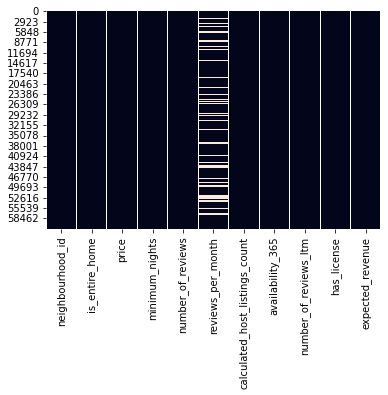

In [32]:
# Print missing values in the dataset.
sns.heatmap(paris_data.isnull(), cbar=False)

In [33]:
# Replace the missing values with zero.
paris_data['reviews_per_month'] = paris_data['reviews_per_month'].fillna(0)

### 5.3. Outliers

In [37]:
# Removing outliers.
from scipy import stats

# How many rows are there?
print('Number of rows before removing outliers: {}'.format(len(paris_data)))

paris_data = paris_data[(np.abs(stats.zscore(paris_data)) < 3).all(axis=1)]

print('Number of rows after removing outliers: {}'.format(len(paris_data)))

# SVR: increases r2 from 0,2 to 0,8 if outliers are removed

Number of rows before removing outliers: 61363
Number of rows after removing outliers: 55509


### 5.4. Correlation

<AxesSubplot:>

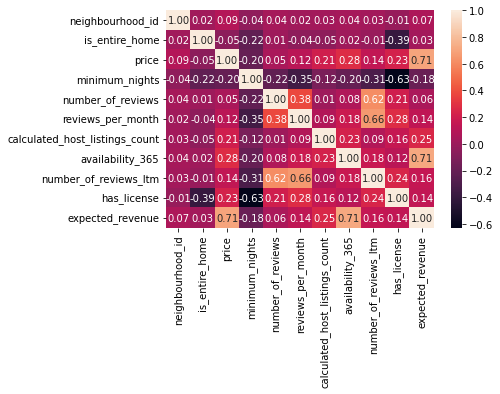

In [107]:
# Correlation matrix
sns.heatmap(paris_data.corr(), annot=True, fmt='.2f')

## 6. Models

### 6.1. Splitting the dataset

In [37]:
# Split the data into features and target label
X = paris_data.drop('price', axis=1)
Y = paris_data['price']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### 6.2. Feature Scaling

In [38]:
# Scale the data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1)).ravel()

### 6.3 Modelling
* SVR
* AdaBoostRegressor
* LinearRegression 
* RandomForestRegressor 
* GradientBoostingRegressor

In [39]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor

print('SVR')
svr = SVR(kernel='rbf', epsilon=0.01, C=3)
svr.fit(X_train, Y_train)
svr_pred = svr.predict(X_test)

print('AdaBoostRegressor')
ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.1)
ada.fit(X_train, Y_train)
ada_pred = ada.predict(X_test)

print('LinearRegression')
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)

print('RandomForestRegressor')
rfg = RandomForestRegressor(n_estimators=100, max_depth=3)
rfg.fit(X_train, Y_train)
rfg_pred = rfg.predict(X_test)

print('GradientBoostingRegressor')
gbd = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gbd.fit(X_train, Y_train)
gbd_pred = gbd.predict(X_test)

SVR
AdaBoostRegressor
LinearRegression
RandomForestRegressor
GradientBoostingRegressor


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluation(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r_squared = r2_score(y_test, y_pred)
    return mae, mse, rmse, r_squared


# Unscale the predictions
svr_pred = scaler.inverse_transform(svr_pred.reshape(-1, 1)).ravel()
ada_pred = scaler.inverse_transform(ada_pred.reshape(-1, 1)).ravel()
lr_pred = scaler.inverse_transform(lr_pred.reshape(-1, 1)).ravel()
rfg_pred = scaler.inverse_transform(rfg_pred.reshape(-1, 1)).ravel()
gbd_pred = scaler.inverse_transform(gbd_pred.reshape(-1, 1)).ravel()

results = []

# SVR
mae, mse, rmse, r_squared = evaluation(Y_test, svr_pred)
results.append({'model': 'SVR', 'mae': mae, 'mse': mse, 'rmse': rmse, 'r_squared': r_squared})

# AdaBoostRegressor
mae, mse, rmse, r_squared = evaluation(Y_test, ada_pred)
results.append({'model': 'AdaBoostRegressor', 'mae': mae, 'mse': mse, 'rmse': rmse, 'r_squared': r_squared})

# LinearRegression
mae, mse, rmse, r_squared = evaluation(Y_test, lr_pred)
results.append({'model': 'LinearRegression', 'mae': mae, 'mse': mse, 'rmse': rmse, 'r_squared': r_squared})

# RandomForestRegressor
mae, mse, rmse, r_squared = evaluation(Y_test, rfg_pred)
results.append({'model': 'RandomForestRegressor', 'mae': mae, 'mse': mse, 'rmse': rmse, 'r_squared': r_squared})

# GradientBoostingRegressor
mae, mse, rmse, r_squared = evaluation(Y_test, gbd_pred)
results.append({'model': 'GradientBoostingRegressor', 'mae': mae, 'mse': mse, 'rmse': rmse, 'r_squared': r_squared})

Text(0, 0.5, 'R2 Score')

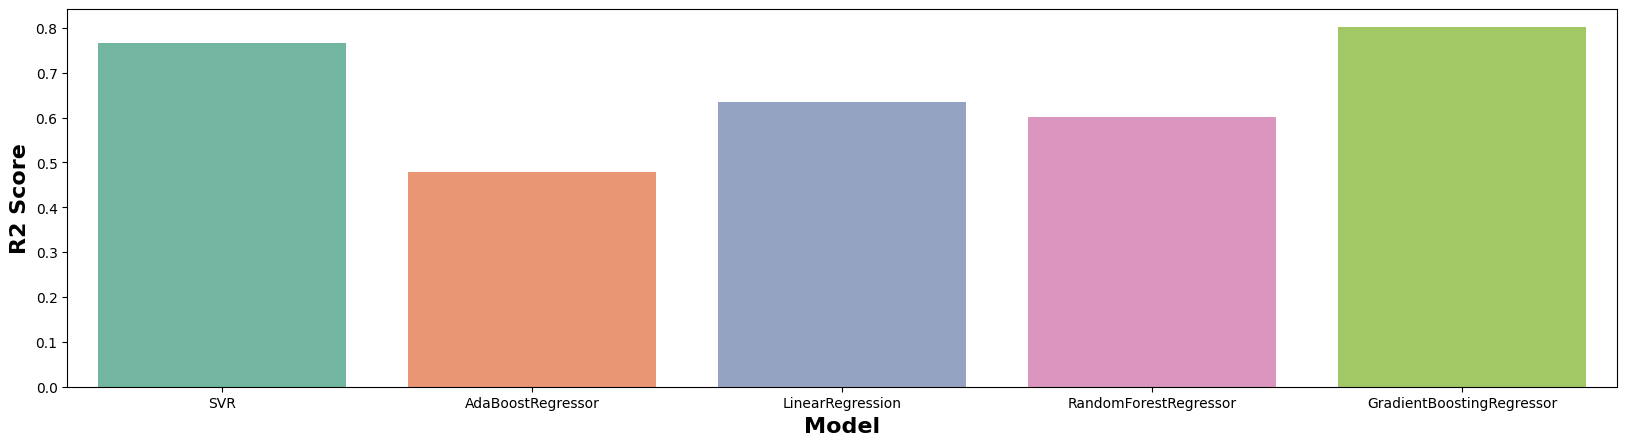

In [41]:
results_plot = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])
for row in results:
    results_plot = results_plot.append({'Model': row['model'], 'MAE': row['mae'], 'MSE': row['mse'], 'RMSE': row['rmse'], 'R2 Score': row['r_squared']}, ignore_index=True)

fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['R2 Score'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('R2 Score', fontdict={'color':'black', 'weight':'bold', 'size': 16})

In [42]:
# Print average price
average_price = paris_data['price'].mean()
print('Average price: ', average_price)

# Print MAE, MSE, RMSE divided by (squared) average price, for each model.
for row in results:
    print(row['model'])
    print('MAE (% of average price): {:.2f}%'.format(row['mae'] / average_price * 100))
    print('RMSE (% of average price): {:.2f}%'.format(row['rmse'] / average_price * 100))
    print()

Average price:  135.48466014520167
SVR
MAE (% of average price): 17.34%
RMSE (% of average price): 42.93%

AdaBoostRegressor
MAE (% of average price): 49.70%
RMSE (% of average price): 64.28%

LinearRegression
MAE (% of average price): 31.57%
RMSE (% of average price): 53.78%

RandomForestRegressor
MAE (% of average price): 34.72%
RMSE (% of average price): 56.16%

GradientBoostingRegressor
MAE (% of average price): 19.84%
RMSE (% of average price): 39.64%



Text(0, 0.5, 'MAE')

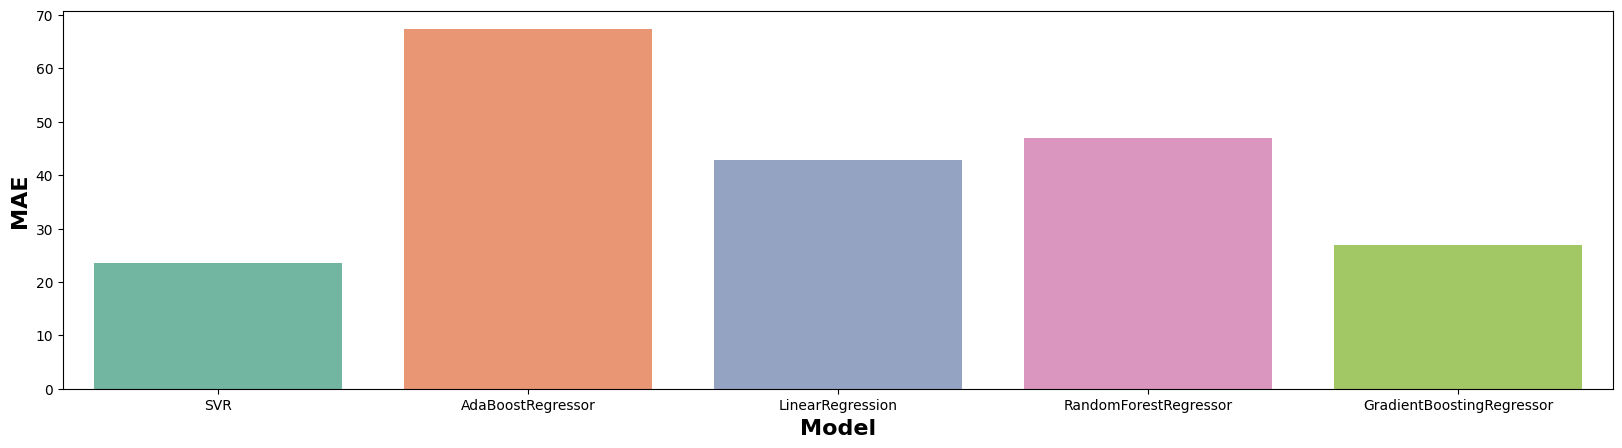

In [43]:
# Plot MAE error (not really concerned about outliers)
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['MAE'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('MAE', fontdict={'color':'black', 'weight':'bold', 'size': 16})

Text(0, 0.5, 'MSE')

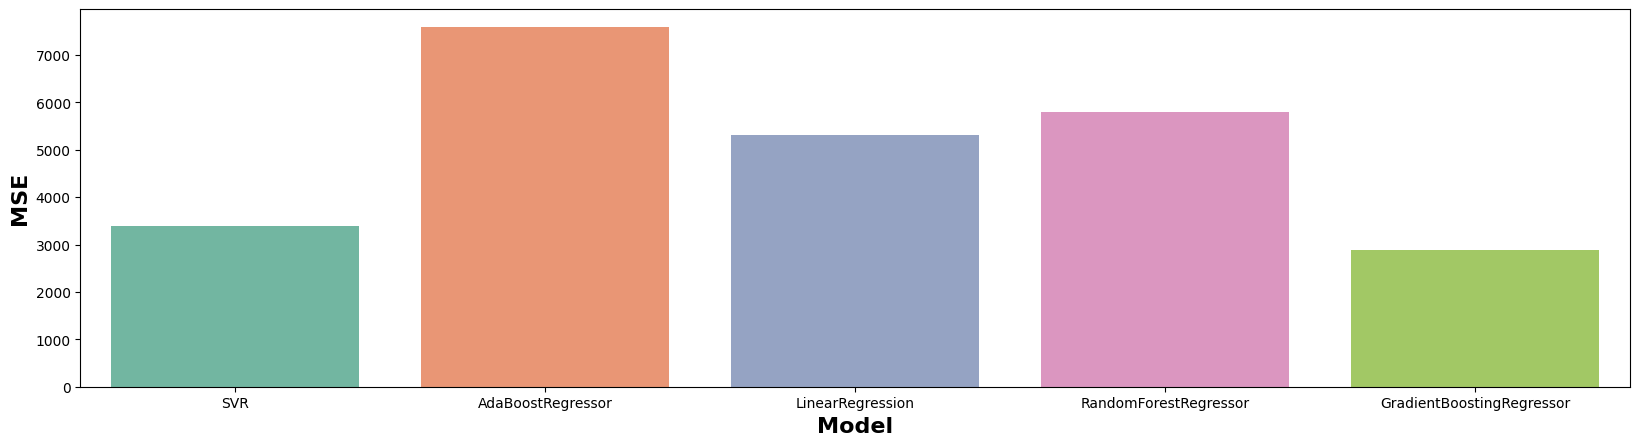

In [44]:
# Plot MSE error (check when treating outliers)
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['MSE'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('MSE', fontdict={'color':'black', 'weight':'bold', 'size': 16})

Text(0, 0.5, 'RMSE')

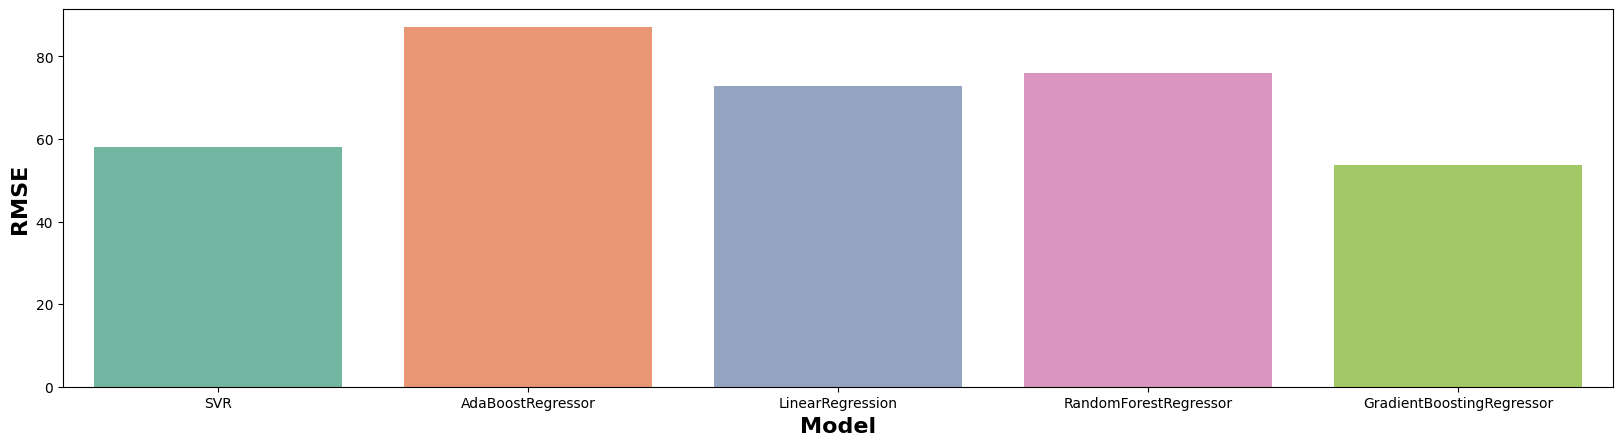

In [45]:
# Plot RMSE error (check when treating outliers)
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['RMSE'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('RMSE', fontdict={'color':'black', 'weight':'bold', 'size': 16})

* Neural Network

In [117]:
# Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from livelossplot import PlotLossesKerasTF

RANDOM_SEED = 420

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.6.2


In [118]:
# Refresh variables
X = paris_data.drop(['price'], axis=1)
Y = paris_data[['price']]

# Scale the data
scaler_x = MinMaxScaler(feature_range=(0, 1)).fit(X)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(Y)

X_scaled = pd.DataFrame(scaler_x.transform(X[X.columns]), columns=X.columns)
Y_scaled = pd.DataFrame(scaler_y.transform(Y[Y.columns]), columns=Y.columns)

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=RANDOM_SEED)

In [119]:
# Build the model
def build_model(activation='relu', learning_rate=0.01):
    model = Sequential()
    model.add(Dense(16, input_dim=10, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='relu'))
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae', 'mse'])
    return model

In [120]:
# Build and summarize the model
model = build_model()
model.summary()

Model: "sequential_407"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1628 (Dense)           (None, 16)                176       
_________________________________________________________________
dense_1629 (Dense)           (None, 8)                 136       
_________________________________________________________________
dense_1630 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_1631 (Dense)           (None, 1)                 9         
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


In [121]:
# Train the model (and tune hyperparameters)
TUNING_DICT = {
    'activation': ['tanh'],
    'learning_rate': [0.01]
}

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32)
grid_search = GridSearchCV(estimator=model, param_grid=TUNING_DICT, cv=kf, scoring='neg_mean_absolute_error', refit = 'True', verbose=1)

grid_search.fit(X_train, Y_train, validation_split=0.2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/20
889/889 [==============================] - 2s 2ms/step - loss: 0.0046 - mae: 0.0414 - mse: 0.0046 - val_loss: 0.0034 - val_mae: 0.0347 - val_mse: 0.0034
Epoch 2/20
889/889 [==============================] - 1s 1ms/step - loss: 0.0035 - mae: 0.0338 - mse: 0.0035 - val_loss: 0.0106 - val_mae: 0.0812 - val_mse: 0.0106
Epoch 3/20
889/889 [==============================] - 1s 1ms/step - loss: 0.0034 - mae: 0.0338 - mse: 0.0034 - val_loss: 0.0028 - val_mae: 0.0263 - val_mse: 0.0028
Epoch 4/20
889/889 [==============================] - 1s 1ms/step - loss: 0.0031 - mae: 0.0314 - mse: 0.0031 - val_loss: 0.0030 - val_mae: 0.0266 - val_mse: 0.0030
Epoch 5/20
889/889 [==============================] - 1s 1ms/step - loss: 0.0031 - mae: 0.0313 - mse: 0.0031 - val_loss: 0.0027 - val_mae: 0.0297 - val_mse: 0.0027
Epoch 6/20
889/889 [==============================] - 1s 1ms/step - loss: 0.0030 - mae: 0.0308 - mse: 0.0030 - val_loss: 

GridSearchCV(cv=KFold(n_splits=5, random_state=420, shuffle=True),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f6e899f7470>,
             param_grid={'activation': ['tanh'], 'learning_rate': [0.01]},
             refit='True', scoring='neg_mean_absolute_error', verbose=1)

In [122]:
# Summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.064800 using {'activation': 'tanh', 'learning_rate': 0.01}
-0.064800 (0.049038) with: {'activation': 'tanh', 'learning_rate': 0.01}


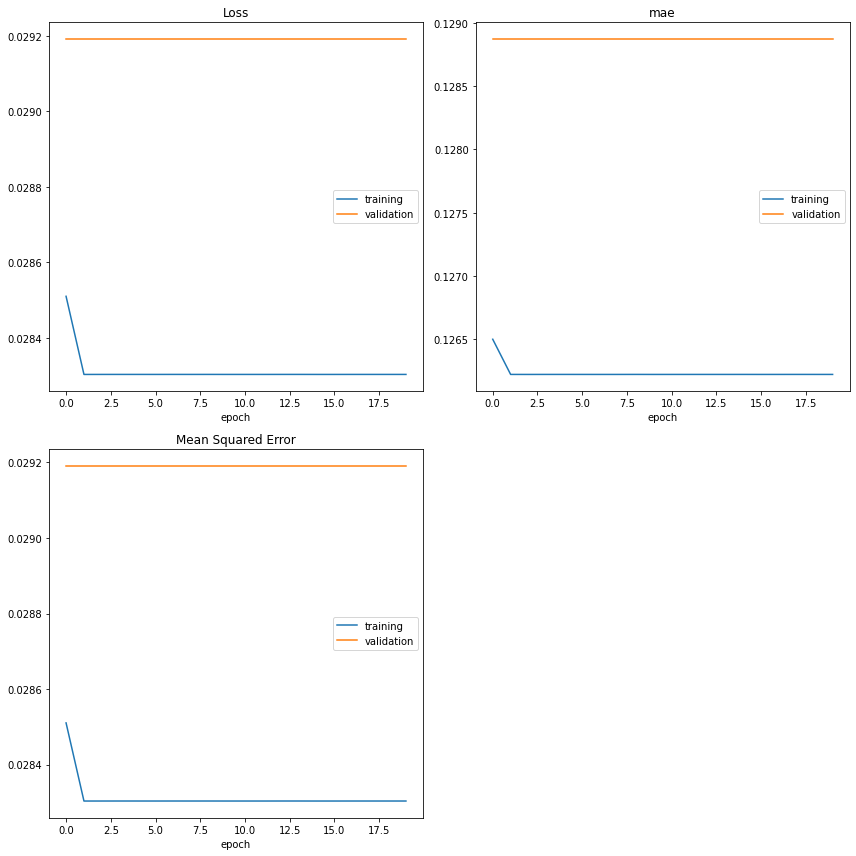

Loss
	training         	 (min:    0.028, max:    0.029, cur:    0.028)
	validation       	 (min:    0.029, max:    0.029, cur:    0.029)
mae
	training         	 (min:    0.126, max:    0.127, cur:    0.126)
	validation       	 (min:    0.129, max:    0.129, cur:    0.129)
Mean Squared Error
	training         	 (min:    0.028, max:    0.029, cur:    0.028)
	validation       	 (min:    0.029, max:    0.029, cur:    0.029)


In [123]:
# Fit the best model
best_mlp_model = grid_search.best_estimator_
best_mlp_model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), callbacks=[PlotLossesKerasTF()], verbose=1)

MAE: 0.12887166911363077
MSE: 0.029191128596258834
RMSE: 0.1708541149526661


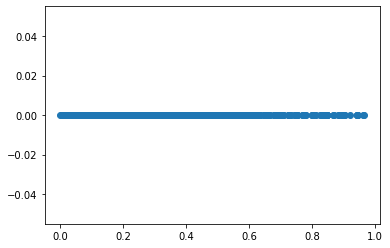

In [124]:
# Predictions
predictions = best_mlp_model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0],1)

# Unscale values (get real values).
predictions_unscaled = scaler_y.inverse_transform(predictions)
y_test_unscaled = scaler_y.inverse_transform(Y_test)

print('MAE:', metrics.mean_absolute_error(Y_test, predictions))
print('MSE:', metrics.mean_squared_error(Y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, predictions)))

plt.scatter(Y_test, predictions)

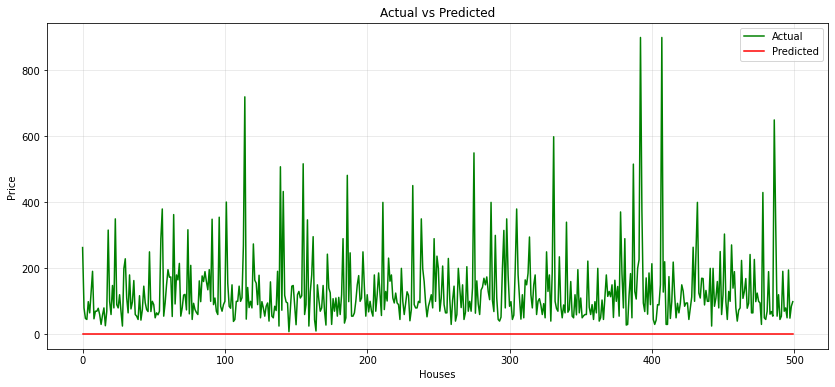

In [125]:
#Visualising the actual and predicted result
def real_predicted_viz(limit):
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_unscaled[:limit], color='green', label='Actual')
    plt.plot(predictions_unscaled[:limit], color='red', label='Predicted')
    plt.grid(alpha=0.3)
    plt.xlabel('Houses')
    plt.ylabel('Price')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()
    
#let's limit to 200 comparisions for better visualization
real_predicted_viz(500)